In [203]:
import numpy as np
import matplotlib.pyplot as plt

# INPUTS

aa = 2
kspring = 1
k = (1.379999999999998e-23)
eps_AA = 5*k                        
eps_BB = 5*k
eps_AB = 1*k
sigmaA = 1
sigmaB = sigmaA / aa
dMax = 0.2
Lbox = 40
number = 10
class Simulation:
    
    def __init__(self,input1 , input2):
        """This function takes as input a dictionary and an integer.
        It uses the dictionary to get the number of polymers and the type of the polymers.
        It uses the integer to get the total number of Steps of the simulation"""
        self.type1 = str(list(input1.keys()))
        self.Npoly = list((list(input1.values()))[0].values())[0]
        self.La = list((list(input1.values()))[0].values())[1]
        self.Lb = list((list(input1.values()))[0].values())[2]
        self.Nsteps = input2
        self.tabE = []
        return
    def initialGenerator (self):
        """This function generate randomly the posiition if the Beads inside our box.
        It also generate the type of the polymers based on their index."""
        self.cordX = np.random.uniform(0, Lbox, size = number*self.Npoly).tolist() # This generate the X cordinates of our beads
        self.cordY = np.random.uniform(0, Lbox, size = number*self.Npoly).tolist() # This generate the Y cordinates of our beads
        self.tabType=[]  #This table is used to have the type of the polymer based on each index. 
        for i in range(self.Npoly):
            c= [0 for i in range(0, self.La)]
            c.extend([1 for i in range(0, self.Lb)])
            self.tabType.extend(c)
        return
    def bondDefiner (self):
        """This function generate the bonds of the monomers.
        Because the beads are generated randomly, we can generate a lit of number from 0 to (Number of Beads -1)
        We then create Npoly slices of that list and they that the index are all bonded"""
        self.bond = [i for i in range(0,((self.La+self.Lb)*self.Npoly))] 
        #Applying what we have stated earlier we have the list of bonds
        #We get a chart like this [0,1,2,3,4,5,6,7,8,9,10,...,numberOfBeads-1]
        #W assumed that the number of polymer is Npoly and we have the degree of polymerization
        #So the bonds of the first polymer would be [0,1,2,3,4,5,6,7,8,9]
        #0 and 1 froming a bond, 1 and 2 then forming a bond etc...
        return
    def LJinteraction (self):
        """This function is used to know which beads are interacting with the Leonard John Potential.
        It divide our squared box into smaller squares of side l superior to RcutOffMax.
        Then it puts the different beads of our system into one of the squares based on its coordinate
        Finally, it shows the neighbours of each square"""
        self.checkboard = [] # Our box divided into smaller squares
        self.sorted = [] # Each index correspond to the index of the beads of the system inside the square of checkboard with this index 
        self.neighbours = [] # Gives the neighbours of the square when considering the whole system
        self.neighboursBeads = [] # Gives the neighbours of the square when considering only one bead
        squareP = [] # index of the square already used
        # Calcul of RcuttoffMax and division of the box into the good number of squares
        rcutoffTab = [(2.5* sigmaA),(2.5 * sigmaB),(2.5 * ((sigmaA+ sigmaB  )/2))]  
        rcutoffMax = max(rcutoffTab)
        n = int(Lbox / rcutoffMax)
        # Creation of the checkboard
        b= np.linspace(0,40,n +1)
        for i in range(len(b) -1):
            x0 = b[i]
            x1 = b[i +1]
            for y in range(len(b) -1) :
                y0 = b[y]
                y1 = b[y+1]
                self.checkboard.append([x0,x1,y0,y1])
                beadsinSquare = []
                for z in range(len(self.cordX)): 
                    x = self.cordX[z]
                    y = self.cordY[z]
                    if x > x0 and x < x1 and y > y0 and y < y1:
                        t = self.cordX.index(x)
                        beadsinSquare.append(t)
                self.sorted.append(beadsinSquare)   
        # Get the neighbours of the squares
        # All the name of variable used there are very short to make the code more elegant and easier to understand
        for i in range(len(self.checkboard)):
            listC=[]    
            listC.append(i)
            listR = []    
            listV=[[self.checkboard[i][0],self.checkboard[i][2]],[self.checkboard[i][0],self.checkboard[i][3]], [self.checkboard[i][1],self.checkboard[i][2]],[self.checkboard[i][1],self.checkboard[i][3]] ]
            squareP.append(i)
            for d in range (len(self.checkboard)):
                s=0
                q = 0
                if d in squareP:
                    s=-500
                listB=[[self.checkboard[d][0],self.checkboard[d][2]],[self.checkboard[d][0],self.checkboard[d][3]], [self.checkboard[d][1],self.checkboard[d][2]],[self.checkboard[d][1],self.checkboard[d][3]] ]
                for z in range(len(listV)):
                    for b in range(len(listB)):
                        if listB[b]==listV[z]:
                            s+=1
                            q+=1
                if s>=1  :
                    listC.append(d)
                if  q>=1:
                    listR.append(d)
            self.neighbours.append(listC) 
            self.neighboursBeads.append(listR)  
        return
    def energyCalculator (self):
        """Because we now have the list of the Bonds and the LJ interactions we can calculate the total Energy of the system.
        This is what this method is exactly doing! It starts by the Energy of the bonds and then the LJs interaction."""
        self.Et = 0
        self.Eb = 0
        self.Elj = 0
        # Using the assumption made earlier calulate the energy of the bonds of the system.
        for i in [y for y in range(0,number*self.Npoly,10)]:
            bondP= self.bond[i:(i+10)]
            for z in range(len(bondP)-1):
                x0= self.cordX[bondP[z]]
                x1= self.cordX[bondP[z+1]]
                y0= self.cordY[bondP[z]]
                y1= self.cordY[bondP[z+1]]
                r = np.sqrt( (x1- x0)**2 + (y1- y0)**2 )
                self.Eb+= 1/2 * (kspring) * ((r) **2) 
        # Calculate the energy of the Lennard Jones potential.
        d=0
        self.listOfInteraction = []  # Gives a list of the index of all the beads involved in the LJ potential
        self.listOfPInteraction = []
        for i in self.sorted:
            neighboursBeadA = self.neighbours[d]
            BeadCloseToA = []
            for z in neighboursBeadA:
                BeadCloseToA.extend(self.sorted[z])
            for y in i:
                indexBeadA = y
                xA = self.cordX[indexBeadA]
                yA = self.cordY[indexBeadA]
                for z in BeadCloseToA:
                    indexBeadB = z
                    interaction = sorted([indexBeadA,indexBeadB])
                    if interaction not in self.listOfPInteraction and interaction[0] != interaction[1]:
                        self.listOfPInteraction.append(interaction)
                        xB = self.cordX[indexBeadB]
                        yB = self.cordY[indexBeadB]
                        typeA = self.tabType[indexBeadA]
                        typeB = self.tabType[indexBeadB]
                        if typeA == typeB:
                            eps = eps_AA
                        else:
                            eps = eps_BB
                        if typeA == 0:
                            sigma1 = sigmaA
                        else:
                            sigma1 = sigmaB
                        if typeB == 0:
                            sigma2 = sigmaA
                        else:
                            sigma2 = sigmaB
                        sigma = (sigma1 + sigma2)/2
                        r = np.sqrt((xA-xB)**2 + (yA-yB)**2)
                        rcutoff = 2.5*sigma
                        if r < rcutoff:
                            self.Elj += 4* eps * ( (sigma/r)**12 - (sigma/r)**6)
                            self.listOfInteraction.append(sorted([indexBeadA,indexBeadB]))
            d+=1
        self.Et = self.Eb + self.Elj
        return
    def step(self):
        """This defninition generate a random move and check wether or not it is accepted.
        Then, it calculate the Energy contribution of the selected bead before the displacement and then after it.
        After, it calculates dE the change in energy and follow the instructions given by the assignement."""
        self.Et = self.Et
        check = 0
        dxMax=0.2
        checkDisplacement = 0
        # Generate a random displacement that is acceptable (in the length of the box) and then consider two beads:
        # The BeadA that is the bead at the index n without any displacement 
        # The BeadB that is the bead at the index n with the displacement 
        while checkDisplacement == 0:
            m=np.random.uniform(-dxMax, dxMax) # generate the size of the move 
            r=np.random.randint(0,2)  # If r = 0 the displacement is in x direction if r = 1 the displacement is in the y direction
            n=np.random.randint(0,number*self.Npoly) # Choose the bead that is going to move
            if r ==0:
                x = self.cordX[n]
                d = x + m
                if  d > 0 and d < Lbox :
                    xa = self.cordX[n]
                    ya = self.cordY[n]
                    xb = d
                    yb = self.cordY[n]
                    checkDisplacement = 1
            else:
                y = self.cordY[n]
                d = y + m
                if  d > 0 and d < Lbox :
                    xa = self.cordX[n]
                    ya = self.cordY[n]
                    xb = self.cordX[n]
                    yb = d
                    checkDisplacement = 1
        # Ounce we have our random displacement with have 2 options;
        #- Recalculte the total energy of the system before and after
        #- Calcualate the energy contribution of BeadA and then of BeadB
        #- Check the change in energy
        #- Because the second option is less computationaly expensive we are going with this one.
        Beadsbonded = [] # Gives a table of the Beads bonded to A and B. They have the same bonds
        indexBond = n
        if (indexBond +1) % 10 == 0:
            Beadsbonded.append(self.bond[indexBond -1])
        elif (indexBond+ 1) % 10 == 1:
            Beadsbonded.append(self.bond[indexBond +1])
        else:
            Beadsbonded.extend([self.bond[indexBond -1], self.bond[indexBond +1]])
        # Calculate the energy contribution of the bonds of each bead or Eharmonic
        Eba = 0 
        Ebb = 0
        for i in Beadsbonded:
            x1 = self.cordX[i]
            y1 = self.cordY[i]
            d1 = np.sqrt( (x1- xa)**2 + (y1- ya)**2 )
            d2 = np.sqrt( (x1- xb)**2 + (y1- yb)**2 )
            Eba += 1/2 * (kspring) * d1**2
            Ebb += 1/2 * (kspring) * d2**2
        # Calculation for the energy contribution made by LJ potential for the BeadA
        Elja = 0
        listLjA = []
        listLJawithA = []
        # We have the list of interaction so we can simply find the ones where A is involved to know it
        # Then we simply calculate it
        for i in range(len(self.listOfInteraction)):
            if n in self.listOfInteraction[i]:
                interaction = self.listOfInteraction[i].copy()
                interaction.remove(n)
                listLjA.extend(interaction)
                listLJawithA.append(self.listOfInteraction[i])
        typeBeadA = self.tabType[n]
        if typeBeadA == 0:
            sigma1 = sigmaA
        else:
            sigma1 = sigmaB
        for i in listLjA:
            indexBeadB = i
            typeBeadB = self.tabType[i]
            xB = self.cordX[i]
            yB = self.cordY[i]
            if typeBeadB == 0:
                sigma2 = sigmaA
            else:
                sigma2 = sigmaB
            sigma = (sigma1 + sigma2) /2
            if typeBeadA == typeBeadB:
                eps = eps_AA
            else:
                eps = eps_AB
            r= np.sqrt((xa-xB)**2 + (ya-yB)**2)
            Elja+= 4* eps * ( (sigma/r)**12 - (sigma/r)**6)
        Eta = Eba + Elja
        # For the LJ potential of BeadB things are more complicated. We need to know in which subsqure it is which the part of the code below does
        subSquareB = []
        for i in range(len(self.checkboard)):
            x0 = self.checkboard[i][0]
            x1 = self.checkboard[i][1]
            y0 = self.checkboard[i][2]
            y1 = self.checkboard[i][3]
            if xb > x0 and xb < x1 and yb > y0 and yb < y1 :
                subSquareB.extend([x0,x1,y0,y1])
        Eljb = 0
        # Then we need to find its neighbours, the beads in its neighbours and finally the index of the beads below rcutoff
        indexsubSquareB = self.checkboard.index(subSquareB)
        listofNeighboursB = self.neighboursBeads[indexsubSquareB]
        listOfBeadsCloseB =[]
        listOfInteractionB = []
        for i in listofNeighboursB:
            listOfBeadsCloseB.extend(self.sorted[i])
        for i in listOfBeadsCloseB:
            x3 = self.cordX[i]
            y3 = self.cordY[i]
            type3 = self.tabType[i]
            if type3 == 0:
                sigma3 = sigmaA
            else:
                sigma3 = sigmaB
            if type3 == typeBeadA:
                eps = eps_AA
            else:
                eps = eps_AB
            sigma = (sigma3 +sigma1)/2
            r = np.sqrt( (x3- xa)**2 + (y3- ya)**2 )
            if r==0:
                r=1000000
            rcutoff = 2.5*sigma
            if r<rcutoff:
                Eljb+= 4* eps * ( (sigma/r)**12 - (sigma/r)**6)
                listOfInteractionB.append(sorted([n,i]))
        Etb = Ebb + Eljb
        # Then we have the value of the dE. If we accept the displacement we need to update some things:
        # The cordinate of the bead with the one of the BeadB
        # In our chart sorted replace the place of the Bead in the right square
        # In the list of Interctions remove all the ones that contain the beadA and repalce them by the interactions of the beadB
        dE = Etb - Eta
        if dE <= 0:
            self.Et = self.Et + dE
            for i in range(len(self.sorted)):
                if n in self.sorted[i]:
                    self.sorted[i].remove(n)

            for i in listLJawithA:
                self.listOfInteraction.remove(i)
            for i in listOfInteractionB:
                self.listOfInteraction.append(i)
            if r == 0:
                self.cordX[n] = xb
            else:
                self.cordY[n] = yb
        else:
            a = np.exp((-dE/k))
            numberN = np.random.uniform(0,1)
            if numberN < a and dE < 0.1*self.Et :
                self.Et = self.Et +dE
                for i in range(len(self.sorted)):
                    if n in self.sorted[i]:
                        self.sorted[i].remove(n)
                self.sorted[indexsubSquareB].append(n)
                for i in listLJawithA:
                    self.listOfInteraction.remove(i) 
                for i in listOfInteractionB:
                    self.listOfInteraction.append(i)
                if r == 0:
                    self.cordX[n] = xb
                else:
                    self.cordY[n] = yb
        return     
    def showMeTheBeads(self):
        """This method as its name states it can be used to show the postion of the Beads.
        It simply splits the list of Beads into 2 lists one of type A and another of type B"""
        tabXa = []
        tabYa = []
        tabXb = []
        tabYb = []
        for i in range((len(self.tabType))):
            typeBead = self.tabType[i]
            if typeBead == 0:
                tabXa.append(self.cordX[i])
                tabYa.append(self.cordY[i])
            if typeBead == 1:
                tabXb.append(self.cordX[i])
                tabYb.append(self.cordY[i])
        plt.scatter(tabXa,tabYa,label = "Beads of type A",color = "blue")
        plt.scatter(tabXb,tabYb, label = "Beads of type B",color= "red")
        plt.title("Position of the Beads ")
        plt.grid(True)
        plt.legend()
        plt.show()
        return
    def saveTheEnergy(self):
        """This method simply takes the value of the Energy of the system in order to plot it later."""
        self.tabE.append(self.Et)
        return

===============   Simulation of the Self-Assembly of Polymers   ===============
At the beginning the total energy of the system is :
127449.37473540158
This is the intital position of the beads:


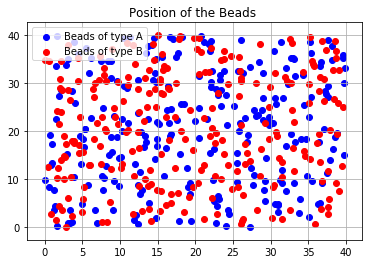

Look carefully the beads of our polymers are moving


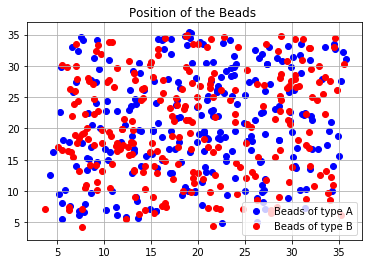

Already 100000 steps!!!!


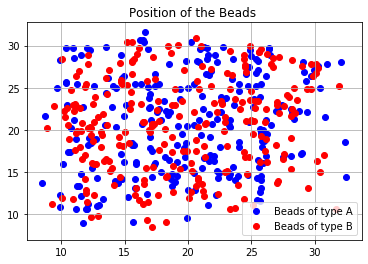

Already 200000 steps!!!!


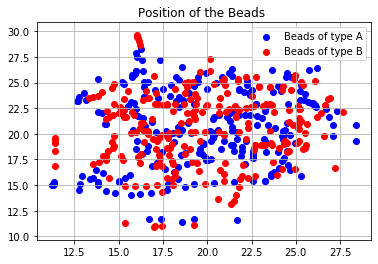

Already 300000 steps!!!!


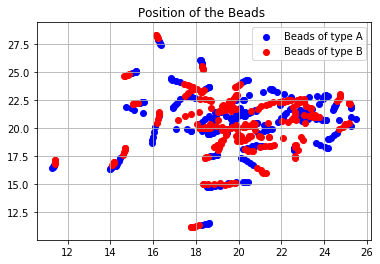

Already 400000 steps!!!!


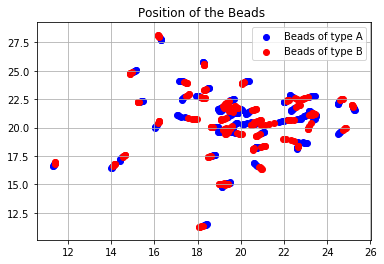

After 500 000 steps, we can consider that the system has reached equilibrium.
The energy of the system is :
1.379369239551207
The average energy of the system is:
2.7587384791024138e-06


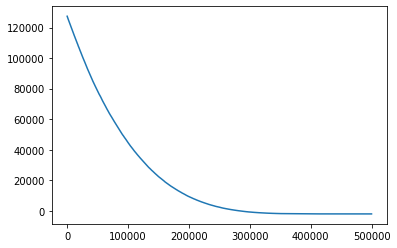

In [202]:
print("===============   Simulation of the Self-Assembly of Polymers   ===============")
simulation = Simulation({"Poly1":{"number": 50,"La":5,"Lb":5}}, 500000) # Here, you can change the number of polymers and bb being La over Lb
simulation.initialGenerator()
simulation.bondDefiner()
simulation.LJinteraction()
simulation.energyCalculator()
print("At the beginning the total energy of the system is :")
print(simulation.Et)
i = 0
t = []
print("This is the intital position of the beads:")
simulation.showMeTheBeads()
print("Look carefully the beads of our polymers are moving")
for i in range(0,simulation.Nsteps):
    simulation.step()
    if i%100000==0 and i !=0:
        simulation.showMeTheBeads()
        print("Already {0} steps!!!!".format(i))
    simulation.saveTheEnergy()
    t.append(i)
simulation.showMeTheBeads()
plt.plot(t,simulation.tabE)
print("After 500 000 steps, we can consider that the system has reached equilibrium.")
print("The energy of the system is :")
simulation.energyCalculator()
print(simulation.Et)
averageE = (simulation.Et/ simulation.Nsteps)
print("The average energy of the system is:")
print(averageE)

===============   Simulation of the Self-Assembly of Polymers   ===============
At the beginning the total energy of the system is :
125161.8470632115
This is the intital position of the beads:


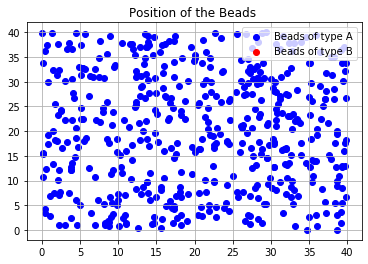

Look carefully the beads of our polymers are moving


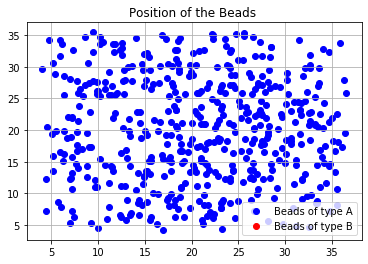

Already 100000 steps!!!!


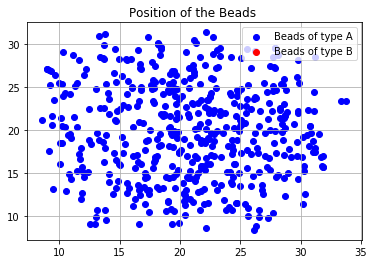

Already 200000 steps!!!!


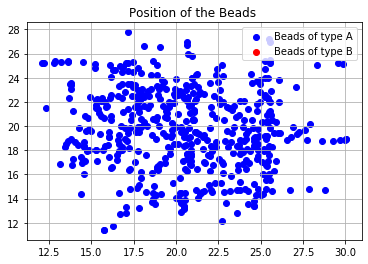

Already 300000 steps!!!!


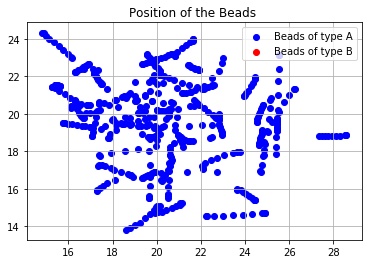

Already 400000 steps!!!!


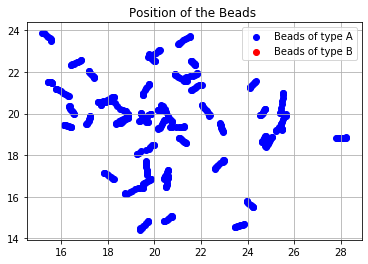

After 500 000 steps, we can consider that the system has reached equilibrium.
The energy of the system is :
1.218365815421687
The average energy of the system is:
2.436731630843374e-06


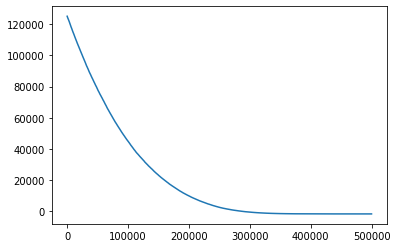

In [204]:
print("===============   Simulation of the Self-Assembly of Polymers   ===============")
simulation = Simulation({"Poly1":{"number": 50,"La":10,"Lb":0}}, 500000) # Here, you can change the number of polymers and bb being La over Lb
simulation.initialGenerator()
simulation.bondDefiner()
simulation.LJinteraction()
simulation.energyCalculator()
print("At the beginning the total energy of the system is :")
print(simulation.Et)
i = 0
t = []
print("This is the intital position of the beads:")
simulation.showMeTheBeads()
print("Look carefully the beads of our polymers are moving")
for i in range(0,simulation.Nsteps):
    simulation.step()
    if i%100000==0 and i !=0:
        simulation.showMeTheBeads()
        print("Already {0} steps!!!!".format(i))
    simulation.saveTheEnergy()
    t.append(i)
simulation.showMeTheBeads()
plt.plot(t,simulation.tabE)
print("After 500 000 steps, we can consider that the system has reached equilibrium.")
print("The energy of the system is :")
simulation.energyCalculator()
print(simulation.Et)
averageE = (simulation.Et/ simulation.Nsteps)
print("The average energy of the system is:")
print(averageE)

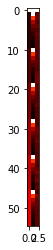

<Figure size 3600x7.2e+17 with 0 Axes>

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

data = np.genfromtxt("HeatMapBigger.csv", delimiter=",")
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.figure(figsize=(50, 10000000000000000))
plt.show()
# We don't know how to make the heatmap better. We have made a separate Excel file but it seems that something is wrong because the Heatmap does not appear